<h1>Predicting Adverse Drug Reactions With Machine Learning</h1>

In [1]:
# Misc
from sklearn.model_selection import train_test_split
from pprint import pprint
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

# Functions
from mlprocess import *
from params_by_label import *

# Fixing the seed
seed = 6
np.random.seed(seed)

""" Careful when importing saved dataframes with label names as indexes -> index = True """

' Careful when importing saved dataframes with label names as indexes -> index = True '

<h2>1. Introduction</h2>
<p>The objective of this work is to develop machine learning (ML) methods that can accurately predict adverse drug reactions (ADRs) using databases like SIDER and OFFSIDES.</p> 
<h2>2. Methods</h2>
<h3>2.1 Methods</h3>
<p>One of the most important factors when using ML methods are the datasets used to train, validate and test the model. In this work, 3 different ones will be used at different stages, shown in table 1.</p> 

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0lax"><span style="font-weight:bold">Dataset</span></th>
    <th class="tg-0lax"><span style="font-weight:bold">Description</span></th>
  </tr>
  <tr>
    <td class="tg-0lax">SIDER 4</td>
    <td class="tg-0lax">1427 Approved drugs with ADRs text-mined from drug package inserts grouped into 27 system organ classes following <br>MedDRA classification</td>
  </tr>
  <tr>
    <td class="tg-0lax">OFFSIDES</td>
    <td class="tg-0lax">Database of off-label side effects</td>
  </tr>
</table>

<h3>2.2 Features</h3>
<p>Features are the set of attributes associated with the example that try to represent the dataset.</p> 
<p>SMILES strings are commonly used to represent molecules, as is used in SIDER, and they will be the basis of this work. But, even though they are a unique representation of molecules, they are not enough to use as a feature in ML. Because of this, they will be used as a way to generate other features like fingerprints and molecular descriptors using tools like RDKit in Python. The general workflow for the datasets when in SIDER format is displayed in the following figure.</p> 



<img src="jupyter_images/sider.png" alt="Drawing" style="width: 600px;"/>

The SIDER dataset consists of a first column with the molecules' SMILES representation and other twenty-seven columns with the different SOCs. Three of these SOCs were not used since they had no real connection with the molecule and, as such, the development of ML models to predict these labels was not useful, these were 'Product Issues', 'Investigations', and 'Social circumstances'. 

With the SMILES representation, it was possible to create multiple different features using RDKit, mainly fingerprint and other descriptors, for example, molecular weight, number of radical electrons, and number of valence electrons. We used these to add relevant information that complements the fingerprint. 

In total, 27 descriptors were calculated for each molecule, not every descriptor was useful and, as such, some selection was required. But, since we had 24 different classification tasks, each with an independent model, and different descriptors had a different importance for each of them, this selection was made independently for each task, what resulted in 24 different DataFrames consisting in the fingerprint representation plus the 3 (after testing different values) descriptors selected to each task. Example in the following table:
<img src="jupyter_images/withdesc.png" alt="Drawing" style="width: 400px;"/>

This selection was made using the SelectKBest function from scikit-learn with ANOVA as the statistical test.
When transforming OFFSIDES and after getting the SMILES from the STITCH IDs, the process is the same as described before.

<h3>2.3 Machine Learning Methods</h3>
<p>Supervised learning is the most common ML scenario in chemoinformatics, and can be subdivided into classification and regression problems. In this type of learning, the training data has the outcome variable to guide the learning process. The objective of this type of learning is to predict the value of an outcome or to classify it. The tested models were:</p> 

<h4>2.3.1 Support Vector Machine (SVM)</h4>
<p>One of the most popular ML methods. It maps the data into a high-dimensional space, using a non-linear kernel function, in order to optimally separate the classes. This separation is done by maximizing the margin between the closest points of the classes, support vectors, to the decision boundary, a hyperplane.</p>

<h4>2.3.2 Random Forest (RF)</h4>
<p>Tries to give a classification based on an ensemble of decision trees built based on the training data. It is an ensemble of tree predictors where each tree is independently constructed by using bootstrap samples of the training data and random feature selection.</p>
<p>After the RF is built, a prediction is made by a majority vote or averaging the predictions of all the trees.</p>

<h4>2.3.3 Gradient Boosted Trees (GBT)</h4>
<p>Similar to RF, as it is also an ensemble prediction method but the trees are not independent. This comes from the fact that, in GBT, at each iteration, the respective tree is constructed by fitting a simple function to current residuals.</p>
<p>The models tested and optimized were SVC (classification implementation of SVM) and Random Forest using scikit-learn, and Gradient Boosted Trees with XGBoost.</p>

<h4>2.3.4 Model Development</h4>
<p>As it is possible to see in following figure, the percentage of positives is very different from label to label. Because of this, the workflow for each model was base cross-validation without any optimizing and balancing, followed by cross-validation with oversampling of the minority class, followed by hyperparameter optimization using random and grid search, followed by a final validation with the optimized parameters and oversampling. This process is shown next. </p>

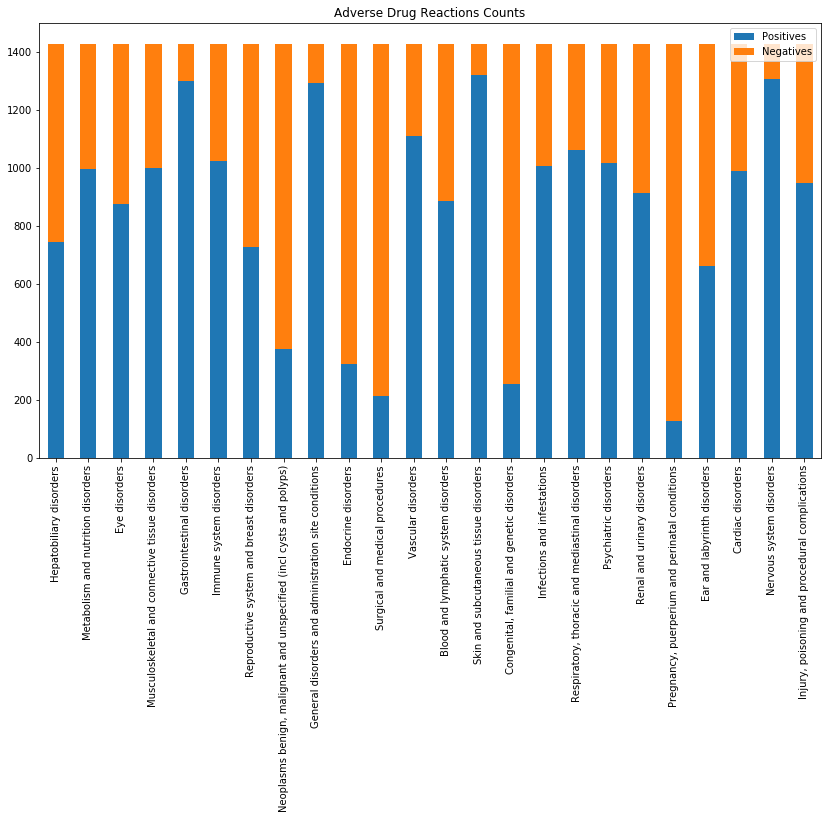

In [22]:
d = {"Positives": y_all.sum(axis=0), "Negatives": 1427 - y_all.sum(axis=0)}
countsm = pd.DataFrame(data=d)
df_perc = countsm / 1427
countsm.plot(kind='bar', figsize=(14, 8), title="Adverse Drug Reactions Counts", ylim=(0, 1500), stacked=True)

ML model development and validation:
<img src="jupyter_images/model.png" alt="Drawing" style="width: 600px;"/>
After replicating this process for the 3 models, the best one for each label was selected and tested with the test dataset.

<h4>2.3.5 Cross-Validation (cv)</h4>
<p>This process was done using stratified k-fold so that each set contains approximately the same percentage of a sample of each target class as the complete set.</p>

<h3>2.4 Class Balancing</h3>
<p>As is seen in figure previous figure, one of the steps when developing the ML models was balancing the dataset. This can be necessary when the classification categories are not approximately equally represented. </p>

<p>Imbalance can, usually, be dealt with by re-sample the dataset, either by over-sampling the minority class and/or under-sampling the majority class. In this work, over-sampling was used, specifically an extension of Synthetic Minority Over-sampling TEchnique (SMOTE) with the imbalanced-learn package, SMOTE-NC. </p>

<p>With SMOTE, the minority class is over-sampled by introducing synthetic examples along the line segments joining k minority class nearest neighbours. SMOTE-NC adapts this strategy by doing something specifically for the categorical features. When generating a new sample, it picks the most frequent category of the nearest neighbours present for these features.</p>

<p>There are some dangers when combining class balancing with cross-validation. In order to keep the validation process valid, balancing should not be done before separating train and validation for each fold. That is, we start the cross-validation process, dividing the training set in training and validation, and only then do we over-sample the minority class (when employing over-sampling). We do this for every iteration of the process. This process will minimize possible overfitting and a change in the test distribution that would result in misleading results. </p>

<h3>2.4 Metrics</h3>
<p>Performance measures for classification are typically based in the confusion matrix.</p>
<img src="jupyter_images/confusionmatrix.png" alt="Drawing" style="width: 200px;"/>

In this matrix, TN is the true negatives, TP is the true positives, FP is the false positives, and FN is the false negatives.

Using this format it is possible to calculate other metrics in order to evaluate the quality of a model's predictions. In order to have a better idea of how well a model works, different metrics should be used, in this work, it was used: Recall, Precision, Average Precision, Area Under the Receiver Operating Characteristic (AUROC), and different variations of F1 score. 

**Precision** is the ability of the classifier not to label as positive a sample that is negative and is defined by:

$$Precision = \frac{\text{TP}}{\text{TP + FP} }$$

**Recall** is the ability of the classifier to label as positive a sample that is positive and is defined by:


$$Recall = \frac{\text{TP}}{\text{TP + FN} }$$


**Average Precision** summarizes a precision-recall curve as the weighted mean of precisions archived at each threshold $(P_{n})$. The increase in recall $(R_{n})$ from the previous threshold $(R_{n-1})$ is used as the weight. It is defined by:


$$AP = \sum_{n} \left ( R_{n} - R_{n-1} \right ) P_{n}$$


**AUROC** is the area under the receiving operating characteristic (ROC) curve. This curve is created by plotting the fraction of TP out of the actual positives against the fraction of FP out of the actual negatives, at different thresholds.
\\

**F1 Score** is a weighted average of the precision and recall and is defined by:


$$F1 = \frac{2 \cdot precision\cdot recall}{precision + recall}$$


In this work, three types of F1-score were used. F1 binary, also represented as F1, is the F1 Score with respect only to the positive label. F1 Macro Score is the unweighted mean between both positive and negative labels. F1 Micro Score uses global TP, FN and FP and is equivalent to the accuracy metric in a binary classification task.

During this work, Average Precision, Recall and the different F1 Scores will be the main metrics used to evaluate and develop the model since they deal with imbalanced datasets better than AUROC.


<h2>3. Results and Discussion</h2>

In this work 24 models were studied, one for each SOC. Before any testing, the dataset was split in train and test and all validation and optimization tasks were done using the first, in order to prevent any type of test overfitting.

Something to have in mind when evaluating these results is the imbalance of the test dataset which is a consequence of the same imbalance of the original dataset. This greatly affects the metrics, mainly the precision and all metrics that derive from it since having a big majority of positive tests will always result in high precision scores.


<h3>3.1 Feature Generation and Selection</h3>

The first step was to choose a fingerprint type and its length. The tested possibilities were ECFP-4, MACCS key, Atom Pairs and Topological Torsion. For each of these types, different lengths between 100 and 2048 were tested and the different metrics were calculated in order to pick the best combination. In order to simplify this process, the different combinations were tested using 10-fold cross-validation with SVC and only to the label 'Hepatobiliary disorders'.
The results are displayed next:


Creating Dataframes


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [08:46<00:00, 40.24s/it]


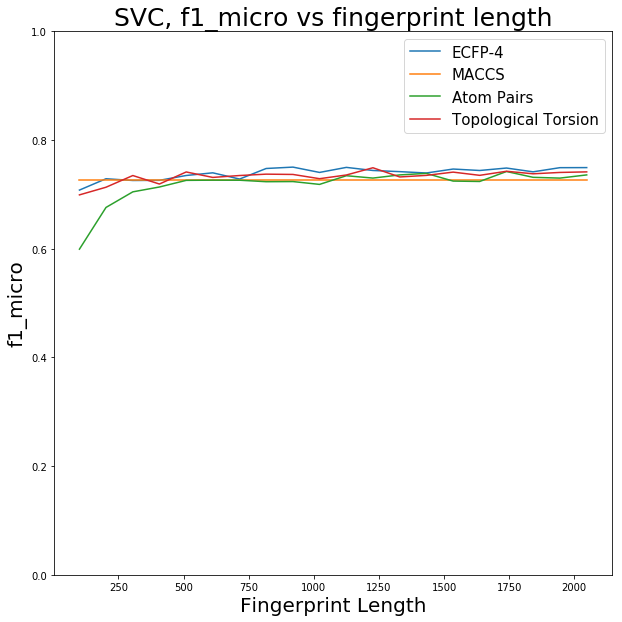

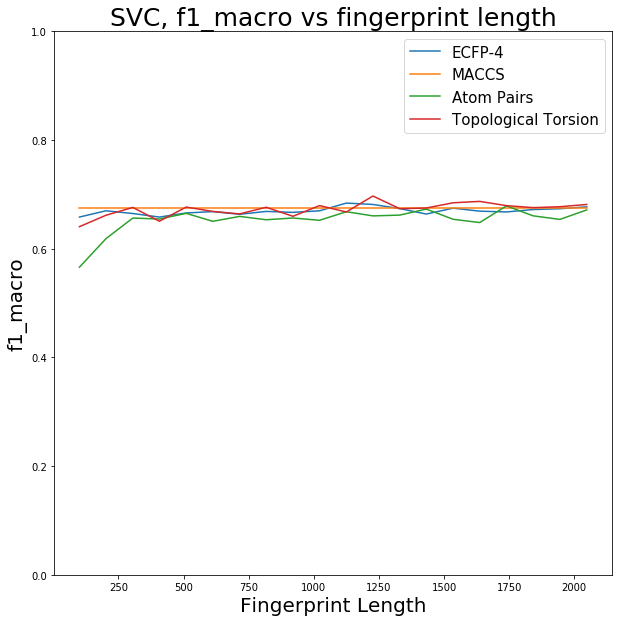

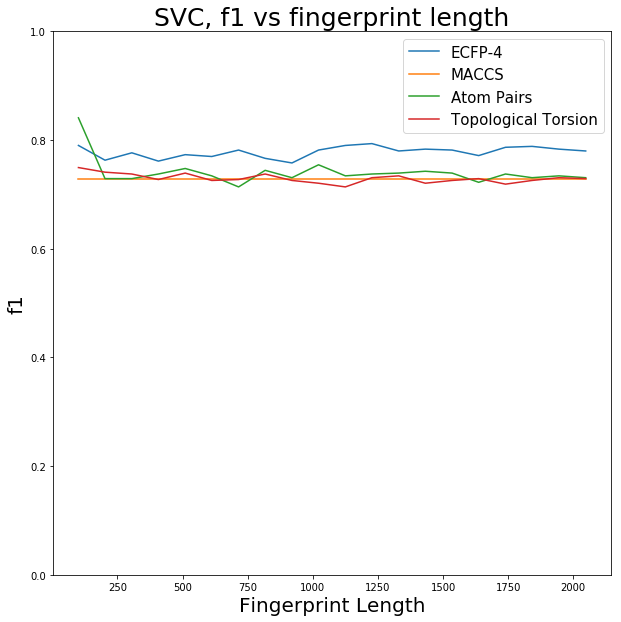

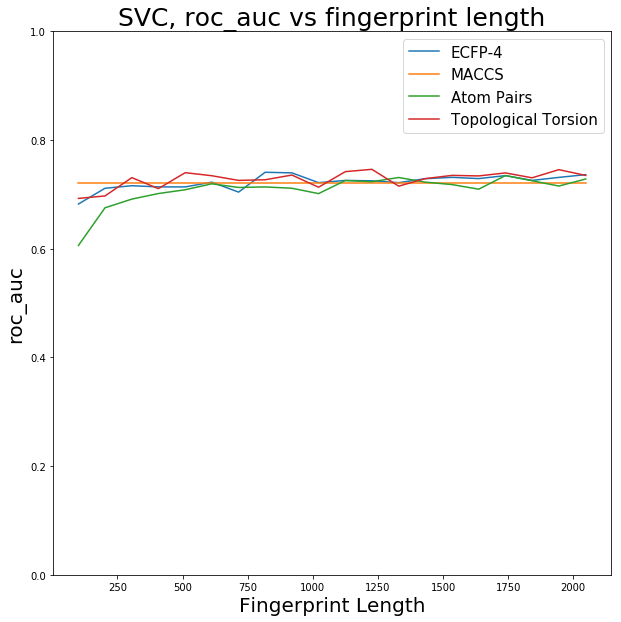

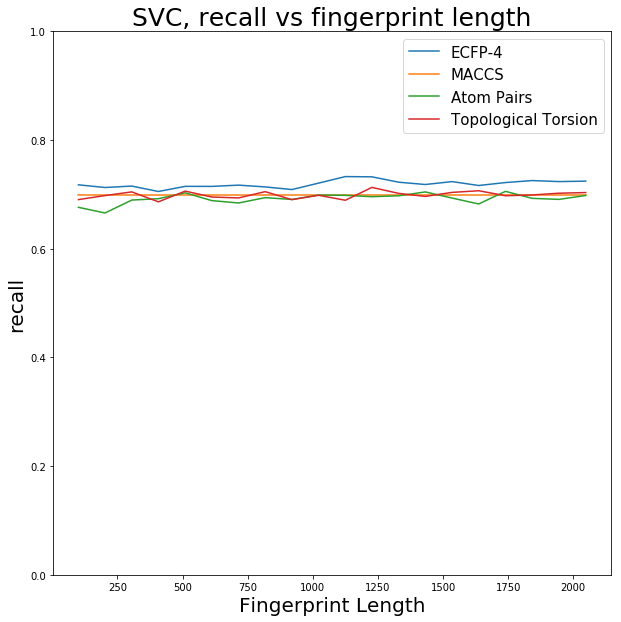

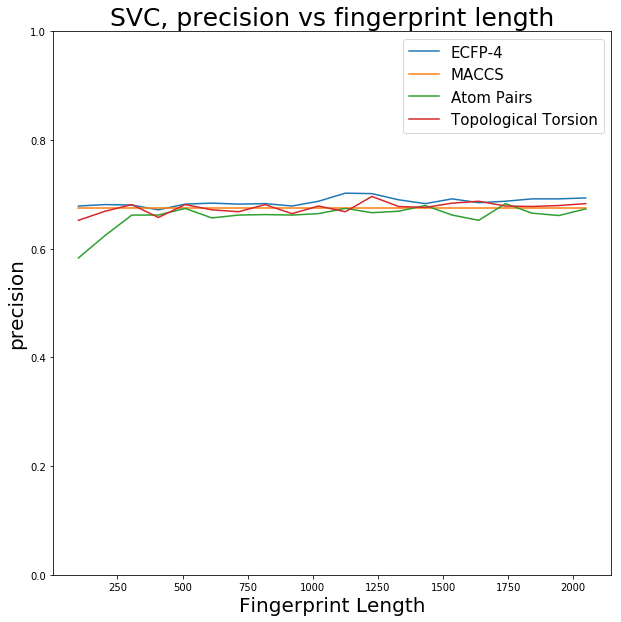

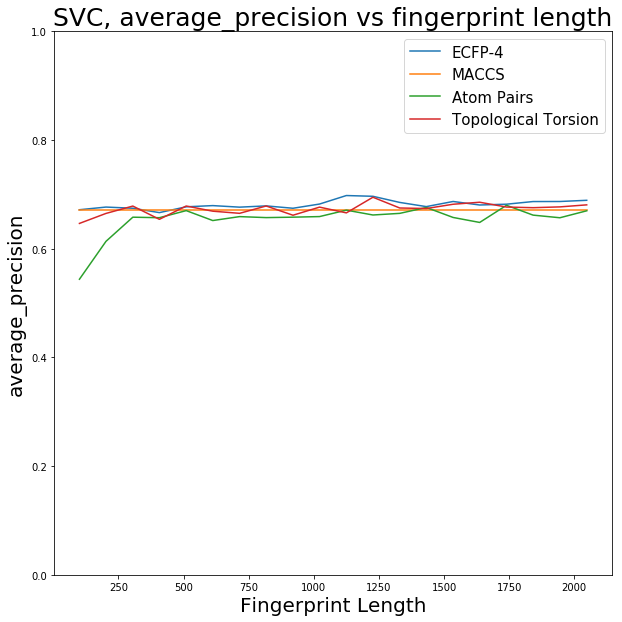

In [2]:
# Creating base df_molecules, df_y with the results vectors, and df_mols_descr with the descriptors
print("Creating Dataframes")
y_all, df_molecules = create_original_df(write_s=False)
df_molecules.drop("smiles", axis=1, inplace=True)
todrop = ["Product issues", "Investigations", "Social circumstances"]
y_all.drop(todrop, axis=1, inplace=True)  # No real connection with the molecule, multiple problems
out_names = y_all.columns.tolist()  # Get class labels

# Separating in a DF_mols_train and an Df_mols_test, in order to avoid data snooping and fitting the model to the test
df_mols_train, df_mols_test, y_train, y_test = train_test_split(df_molecules, y_all, test_size=0.2, random_state=seed)

# Fingerprint length
all_df_results_svc = test_fingerprint_size(df_mols_train, y_train, SVC(gamma="scale", random_state=seed), makeplots=True, write=False)
# Best result with ECFP-4 at 1125 - This will be used to all results


After analysing the results, the performance appeared to be similar across the board with a small advantage when using ECFP-4. In this fingerprint type a small peak of performance was seen at length 1125, so that was the chosen combination.

In [6]:

# Create X datasets with fingerprint length
X_all, _, _, _ = createfingerprints(df_molecules, length=1125)
X_train_fp, _, _, _ = createfingerprints(df_mols_train, length=1125)
X_test_fp, _, _, _ = createfingerprints(df_mols_test, length=1125)

# Selects and create descriptors dataset
df_desc = createdescriptors(df_molecules)  # Create all descriptors

# Splits in train and test
df_desc_base_train, df_desc_base_test = train_test_split(df_desc, test_size=0.2, random_state=seed)

# Creates a dictionary with key = class label and value = dataframe with fingerprint + best K descriptors for that label
X_train_dic, X_test_dic, selected_cols = create_dataframes_dic(df_desc_base_train, df_desc_base_test, X_train_fp,
                                                               X_test_fp, y_train, out_names, score_func=f_classif, k=3)
# Creates a y dictionary for all labels
y_train_dic = {name: y_train[name] for name in out_names}
modelnamesvc = {name: "SVC" for name in out_names}
modelnamerf = {name: "RF" for name in out_names}
modelnamexgb = {name: "XGB" for name in out_names}
modelnamevot = {name: "VotingClassifier" for name in out_names}

100%|█████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 117.20it/s]


In [12]:
print("Selected descriptors by label:")
pprint(selected_cols, width=-1)

Selected descriptors by label:
{'Blood and lymphatic system disorders': ['fracsp33',
                                          'aliphcarbocycles',
                                          'numsatcarbcycles'],
 'Cardiac disorders': ['arocarbocycles',
                       'arorings',
                       'numsatcarbcycles'],
 'Congenital, familial and genetic disorders': ['maxabspartcharge',
                                                'numrade',
                                                'arocarbocycles'],
 'Ear and labyrinth disorders': ['maxpartcharge',
                                 'aliphcarbocycles',
                                 'numsatcarbcycles'],
 'Endocrine disorders': ['numrade',
                         'aliphcarbocycles',
                         'numsatcarbcycles'],
 'Eye disorders': ['nhohcount',
                   'numhdonors',
                   'numhatoms'],
 'Gastrointestinal disorders': ['aliphcarbocycles',
                                'arorings'

<h3>3.2 Model Development</h3>
<h4>3.2.1 SVC</h4>
As was said previously the first step was to test if the oversampling of the dataset improved the model.

In [14]:
print("SVC")
print("Base SVC without balancing:")
base_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed), n_splits=5,
                                  n_jobs=-2, verbose=False)

SVC
Base SVC without balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:13<00:00,  2.84s/it]


In [18]:
print("Scores for SVC without balancing:")
base_svc_report

Scores for SVC without balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.712,0.643,0.622,0.676,0.851,0.612,0.660
Metabolism and nutrition disorders,0.818,0.692,0.409,0.565,1.000,0.692,0.732
Eye disorders,0.763,0.624,0.430,0.597,0.984,0.622,0.687
Musculoskeletal and connective tissue disorders,0.815,0.687,0.407,0.648,1.000,0.687,0.802
Gastrointestinal disorders,0.951,0.907,0.476,0.672,1.000,0.907,0.945
Immune system disorders,0.841,0.726,0.421,0.559,1.000,0.726,0.777
Reproductive system and breast disorders,0.609,0.608,0.608,0.652,0.611,0.608,0.625
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.000,0.745,0.427,0.679,0.000,0.000,0.470
General disorders and administration site conditions,0.953,0.910,0.476,0.603,1.000,0.910,0.938
Endocrine disorders,0.000,0.786,0.440,0.631,0.000,0.000,0.391


In [19]:
print("Base SVC with balancing:")
base_bal_svc_report = cv_multi_report(X_train_dic, y_train, out_names, SVC(gamma="auto", random_state=seed),
                                      balancing=True, n_splits=5, n_jobs=-2, verbose=False, random_state=seed)

Base SVC with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [21:26<00:00, 53.81s/it]


In [28]:
print("Scores for SVC with balancing:")
base_bal_svc_report

Scores for SVC with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.654,0.628,0.624,0.675,0.678,0.633,0.655
Metabolism and nutrition disorders,0.701,0.603,0.553,0.587,0.676,0.730,0.758
Eye disorders,0.702,0.607,0.560,0.608,0.754,0.658,0.699
Musculoskeletal and connective tissue disorders,0.742,0.646,0.588,0.633,0.741,0.744,0.781
Gastrointestinal disorders,0.905,0.833,0.602,0.720,0.880,0.932,0.956
Immune system disorders,0.776,0.664,0.553,0.594,0.800,0.754,0.791
Reproductive system and breast disorders,0.607,0.607,0.607,0.652,0.608,0.608,0.625
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.331,0.640,0.542,0.584,0.350,0.314,0.331
General disorders and administration site conditions,0.902,0.825,0.524,0.577,0.890,0.915,0.928
Endocrine disorders,0.262,0.698,0.536,0.557,0.250,0.279,0.277


In [21]:
diff_bal_svc = base_bal_svc_report - base_svc_report
print("Changes in scores after balancing:")
diff_bal_svc

Changes in scores after balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,-0.058,-0.015,0.002,-0.001,-0.173,0.021,-0.005
Metabolism and nutrition disorders,-0.117,-0.089,0.144,0.022,-0.324,0.038,0.026
Eye disorders,-0.061,-0.017,0.130,0.011,-0.230,0.036,0.012
Musculoskeletal and connective tissue disorders,-0.073,-0.041,0.181,-0.015,-0.259,0.057,-0.021
Gastrointestinal disorders,-0.046,-0.074,0.126,0.048,-0.120,0.025,0.011
Immune system disorders,-0.065,-0.062,0.132,0.035,-0.200,0.028,0.014
Reproductive system and breast disorders,-0.002,-0.001,-0.001,0.000,-0.003,0.000,0.000
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.331,-0.105,0.115,-0.095,0.350,0.314,-0.139
General disorders and administration site conditions,-0.051,-0.085,0.048,-0.026,-0.110,0.005,-0.010
Endocrine disorders,0.262,-0.088,0.096,-0.074,0.250,0.279,-0.114


As we can see by some of the results that are displayed in the previous tables, even though Average Precision didn't change by much, the biggest change of all the metrics was in the F1 Macro score. As this is the unweighted mean of F1 score to both negative and positive classes, we can conclude that an improvement of the F1 score in the minority class was the main consequence of the oversampling, as was to be expected. 

With these positive results, oversampling was applied when developing every model. 

The next step in the model development was hyperparameter optimization. In SVC, two parameters optimize using grid search with cross-validation - C and gamma - while using a Radial Basis Function (RBF) kernel, where C is the cost of misclassifying training examples and gamma is a specific parameter of RBF kernel and can be seen as the inverse of the radius of influence of the samples selected as support vectors.

In [26]:
# Searching best parameters
params_to_test = {"svc__kernel": ["rbf"], "svc__C": [0.01, 0.1, 1, 10],
                  "svc__gamma": [0.001, 0.01, 0.1, 1]}
d_params_to_test = {name: params_to_test for name in out_names}

"""This code was previously executed and its output saved"""
#best_SVC_params_by_label = multi_label_grid_search(X_train_dic, y_train, out_names[15:],
#                                                   SVC(gamma="auto", random_state=seed), d_params_to_test,
#                                                   balancing=True, n_splits=5, scoring="f1_micro", n_jobs=-2,
#                                                   verbose=True, random_state=seed)
pprint(best_SVC_params_by_label, width=-1)

{'Blood and lymphatic system disorders': {'svc__C': 10,
                                          'svc__gamma': 0.01,
                                          'svc__kernel': 'rbf'},
 'Cardiac disorders': {'svc__C': 10,
                       'svc__gamma': 0.1,
                       'svc__kernel': 'rbf'},
 'Congenital, familial and genetic disorders': {'svc__C': 0.01,
                                                'svc__gamma': 1,
                                                'svc__kernel': 'rbf'},
 'Ear and labyrinth disorders': {'svc__C': 10,
                                 'svc__gamma': 0.01,
                                 'svc__kernel': 'rbf'},
 'Endocrine disorders': {'svc__C': 0.01,
                         'svc__gamma': 1,
                         'svc__kernel': 'rbf'},
 'Eye disorders': {'svc__C': 10,
                   'svc__gamma': 0.1,
                   'svc__kernel': 'rbf'},
 'Gastrointestinal disorders': {'svc__C': 0.01,
                                'svc__gamma'

In [27]:
print("Improved SVC with balancing:")
impr_bal_svc_report = cv_multi_report(X_train_dic, y_train, out_names, modelname=modelnamesvc,
                                      spec_params=best_SVC_params_by_label, balancing=True, n_splits=5, n_jobs=-2,
                                      verbose=False, random_state=seed)

Improved SVC with balancing:


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [26:49<00:00, 65.60s/it]


In [30]:
print("Scores for optimized SVC with balancing:")
impr_bal_svc_report

Scores for optimized SVC with balancing:


,F1 Binary,F1 Micro,F1 Macro,ROC_AUC,Recall,Precision,Average Precision
Hepatobiliary disorders,0.709,0.682,0.678,0.730,0.751,0.674,0.701
Metabolism and nutrition disorders,0.810,0.693,0.507,0.597,0.944,0.709,0.757
Eye disorders,0.754,0.637,0.532,0.633,0.906,0.646,0.720
Musculoskeletal and connective tissue disorders,0.812,0.704,0.553,0.669,0.932,0.720,0.798
Gastrointestinal disorders,0.951,0.907,0.476,0.617,1.000,0.907,0.929
Immune system disorders,0.839,0.734,0.531,0.612,0.958,0.747,0.793
Reproductive system and breast disorders,0.677,0.681,0.680,0.725,0.672,0.685,0.722
"Neoplasms benign, malignant and unspecified (incl cysts and polyps)",0.000,0.745,0.427,0.648,0.000,0.000,0.345
General disorders and administration site conditions,0.953,0.910,0.476,0.589,1.000,0.910,0.931
Endocrine disorders,0.000,0.786,0.440,0.574,0.000,0.000,0.262
